## Loading Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta
import numpy as np

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder
from scipy.stats.mstats import winsorize
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet, Lasso, RidgeCV,LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor,RandomForestRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

## Loading the training and the testing dataset

In [2]:
train = pd.read_excel('Data_Train.xlsx')
train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
test = pd.read_excel('Test_Set.xlsx')
test.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [4]:
print("Training Dataset Shape:",train.shape)
print("Test Dataset Shape:",test.shape)

Training Dataset Shape: (10683, 11)
Test Dataset Shape: (2671, 10)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   object
 9   Additional_Info  2671 non-null   object
dtypes: object(10)
memory usage: 208.8+ KB


In [7]:
train.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [8]:
train.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [9]:
test.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64

#### Observation:

There are two null values, let's observe them

In [10]:
train[train.isnull().any(axis=1)]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


#### Observation:

Both of them are from the same row which is quite less to impute, we can drop the null row

In [11]:
train.dropna(inplace = True)

## Exploratory Data Analysis

In [12]:
print('Observing the airline column:')
train['Airline'].value_counts()

Observing the airline column:


Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

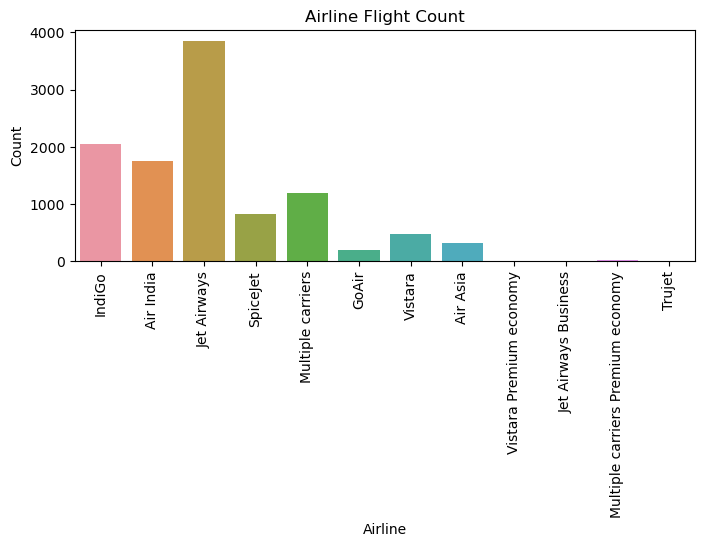

In [13]:
plt.figure(figsize=(8,3))
sns.countplot(x='Airline',data=train)
plt.title('Airline Flight Count')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

#### Observation:

There is a lot more data on Jetairways which could lead to a slight bias in the model. There occurances for Vistara Premium economy, Jet Airways Business, Multiple Carriers Premium Economy, Truejet is quite less - this could add some noise to the model. We shall deal with it later

Observing the Price column for each airline: 


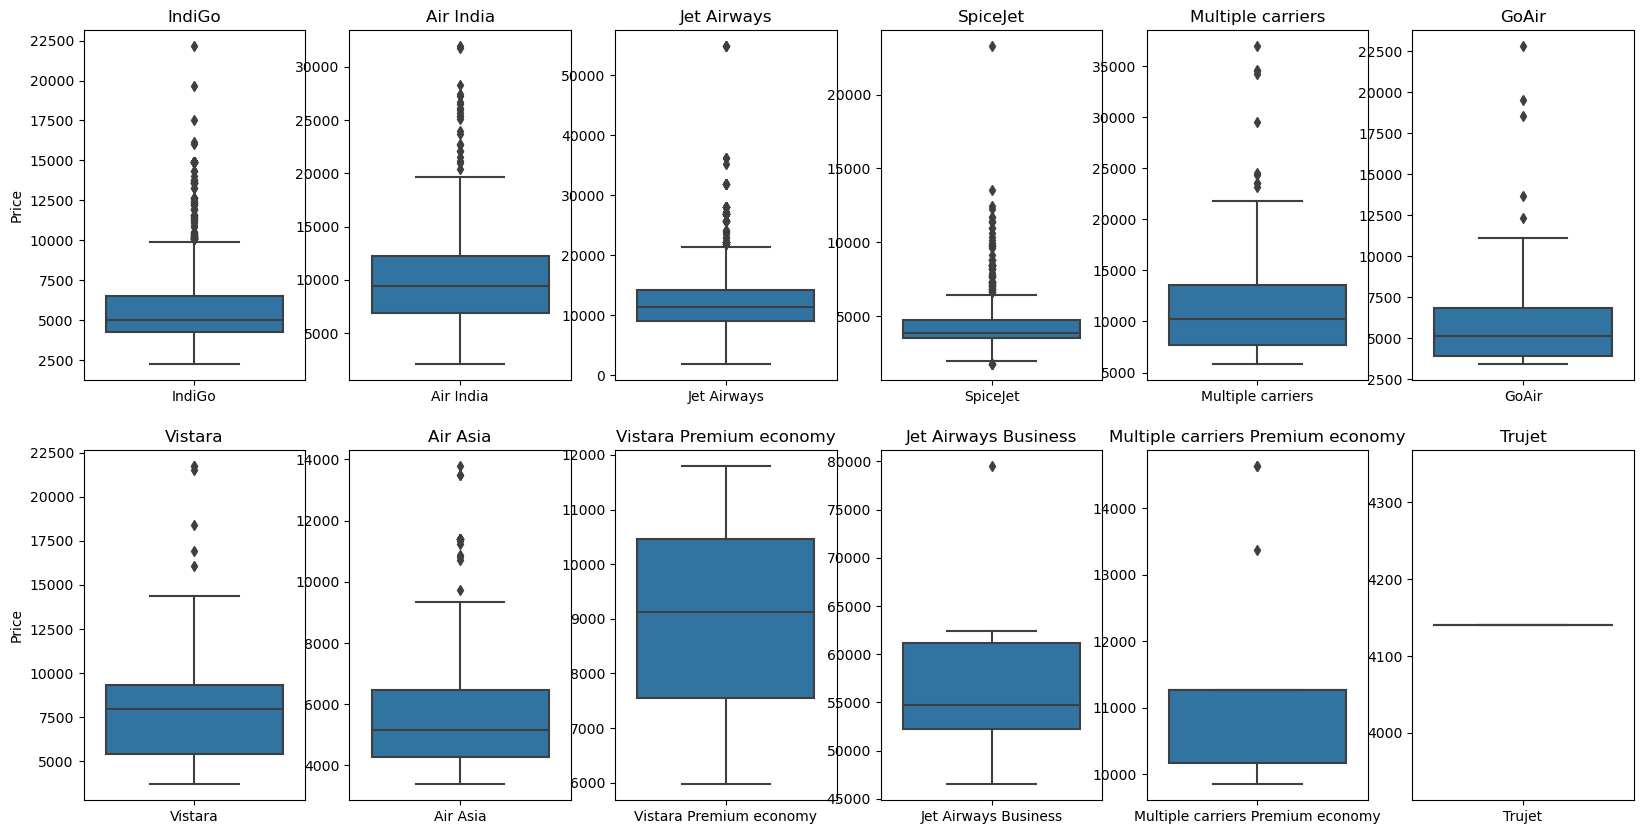

In [14]:
print('Observing the Price column for each airline: ')
unique_airlines = train['Airline'].unique()
n = 6
num_rows = int(np.ceil(len(unique_airlines) / n))

plt.figure(figsize=(20, 5 * num_rows))

for i, airline in enumerate(unique_airlines):
    plt.subplot(num_rows,n,i + 1)
    sns.boxplot(data=train[train['Airline']==airline], x='Airline', y='Price')
    plt.title(airline)
    plt.xlabel('')
    plt.ylabel('Price' if i % n == 0 else '')
plt.show()

#### Observation:

There are quite a few price outliers for Indigo, AirIndia, Jet Airways, SpiceJet. It could be be because of the number of flights for each of the flight and the different routes and destinations. We shall explore this later

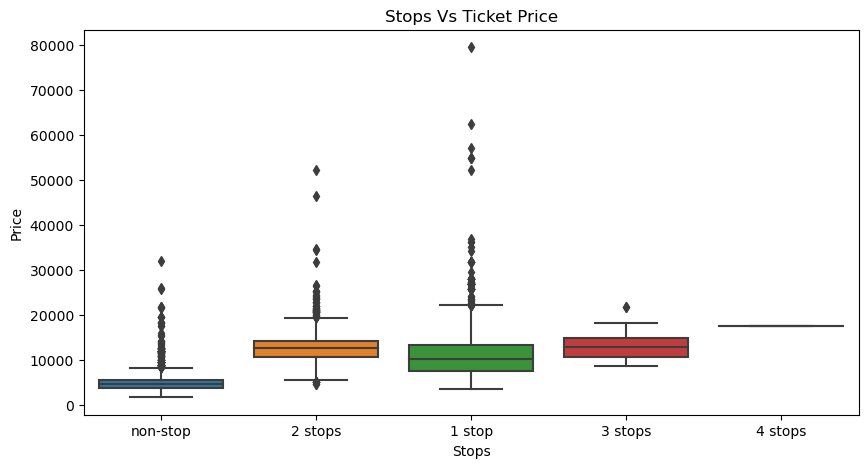

In [15]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Total_Stops',y='Price',data=train)
plt.title('Stops Vs Ticket Price')
plt.xlabel('Stops')
plt.ylabel('Price')
plt.show()

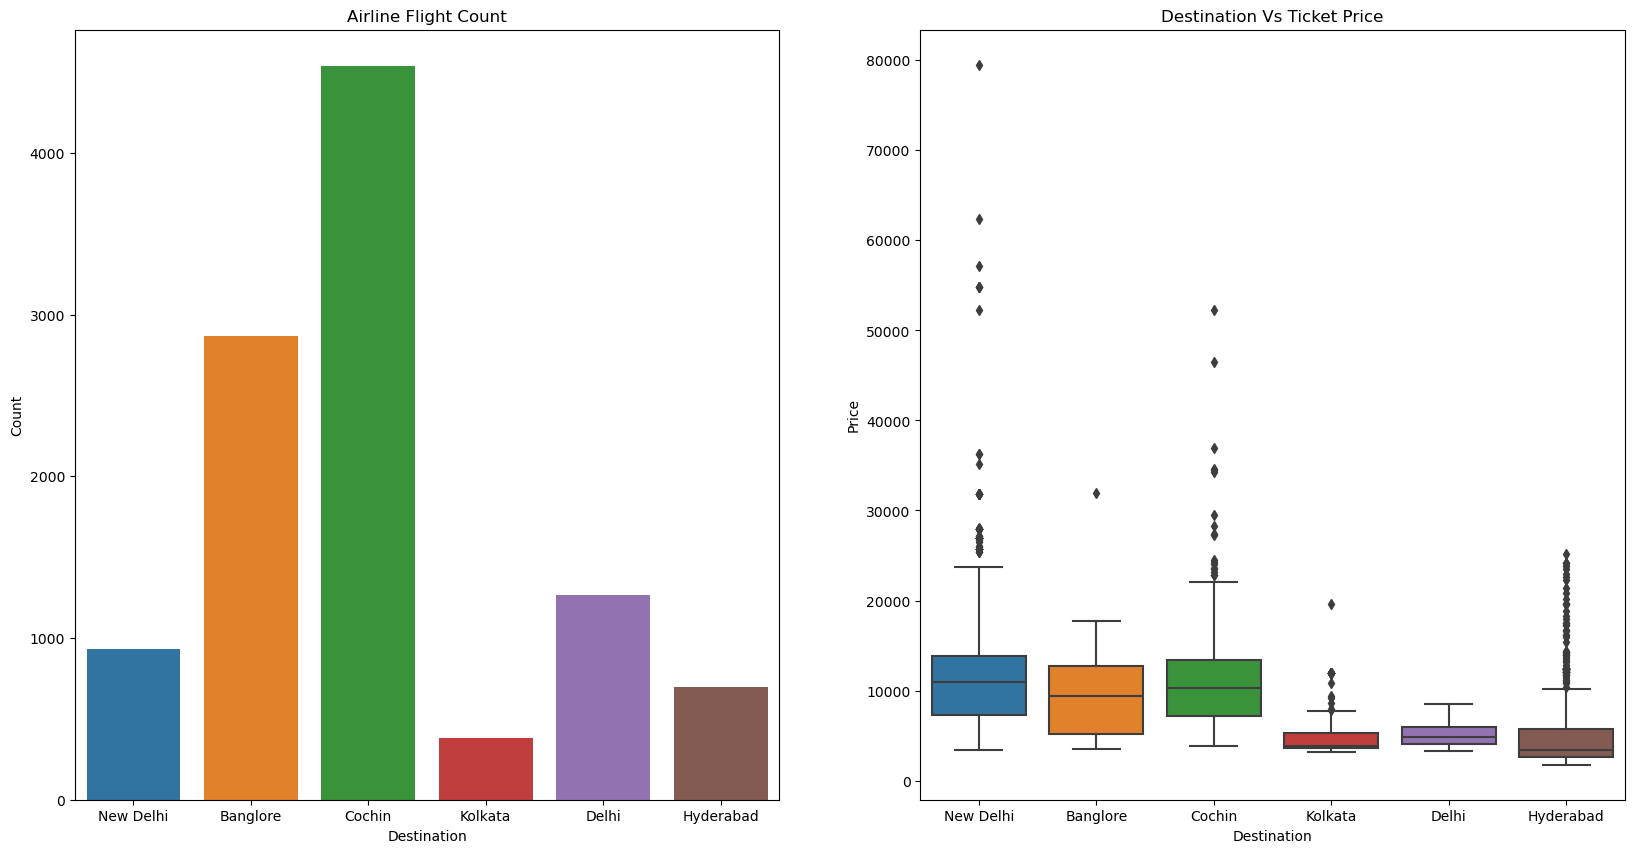

In [16]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.countplot(x='Destination',data=train)
plt.title('Airline Flight Count')
plt.ylabel('Count')

plt.subplot(1,2,2)
sns.boxplot(x='Destination',y='Price',data=train)
plt.title('Destination Vs Ticket Price')
plt.xlabel('Destination')
plt.ylabel('Price')

plt.show()

#### Observation:

We can see that the outliers are quite high for Cochin because of the number of flights headed across multiple locations. For New Delhi and Hyderabad, it could be because of their metropolitan status.

We can also observe that New Delhi and Delhi are being treated differently here, this will be dealt with later

## Feature Engineering

In [17]:
def classify_flight_time(time_str):
    time = datetime.strptime(time_str, '%H:%M').time()
    if time >= datetime.strptime('00:00', '%H:%M').time() and time < datetime.strptime('06:00', '%H:%M').time():
        return 'Early Morning'
    elif time >= datetime.strptime('06:00', '%H:%M').time() and time < datetime.strptime('12:00', '%H:%M').time():
        return 'Morning'
    elif time >= datetime.strptime('12:00', '%H:%M').time() and time < datetime.strptime('18:00', '%H:%M').time():
        return 'Afternoon'
    elif time >= datetime.strptime('18:00', '%H:%M').time() and time < datetime.strptime('22:00', '%H:%M').time():
        return 'Evening'
    else:
        return 'Late Night'

train['Departure'] = train['Dep_Time'].apply(classify_flight_time)
test['Departure'] = test['Dep_Time'].apply(classify_flight_time)

In [18]:
def calculate_arrival(departure, duration):
    departure_time = datetime.strptime(departure, "%H:%M")    
    if 'h' in duration:
        parts = duration.split('h')
        hours = int(parts[0]) if parts[0] else 0
        minutes = int(parts[1].strip().replace('m', '')) if parts[1] else 0
    else:
        hours = 0
        minutes = int(duration.replace('m', ''))
    arrival_time = departure_time + timedelta(hours=hours, minutes=minutes)
    return arrival_time.strftime("%H:%M")

train['Arr_Time'] = train.apply(lambda row: calculate_arrival(row['Dep_Time'], row['Duration']), axis=1)
train['Arrival'] = train['Arr_Time'].apply(classify_flight_time)

test['Arr_Time'] = test.apply(lambda row: calculate_arrival(row['Dep_Time'], row['Duration']), axis=1)
test['Arrival'] = test['Arr_Time'].apply(classify_flight_time)

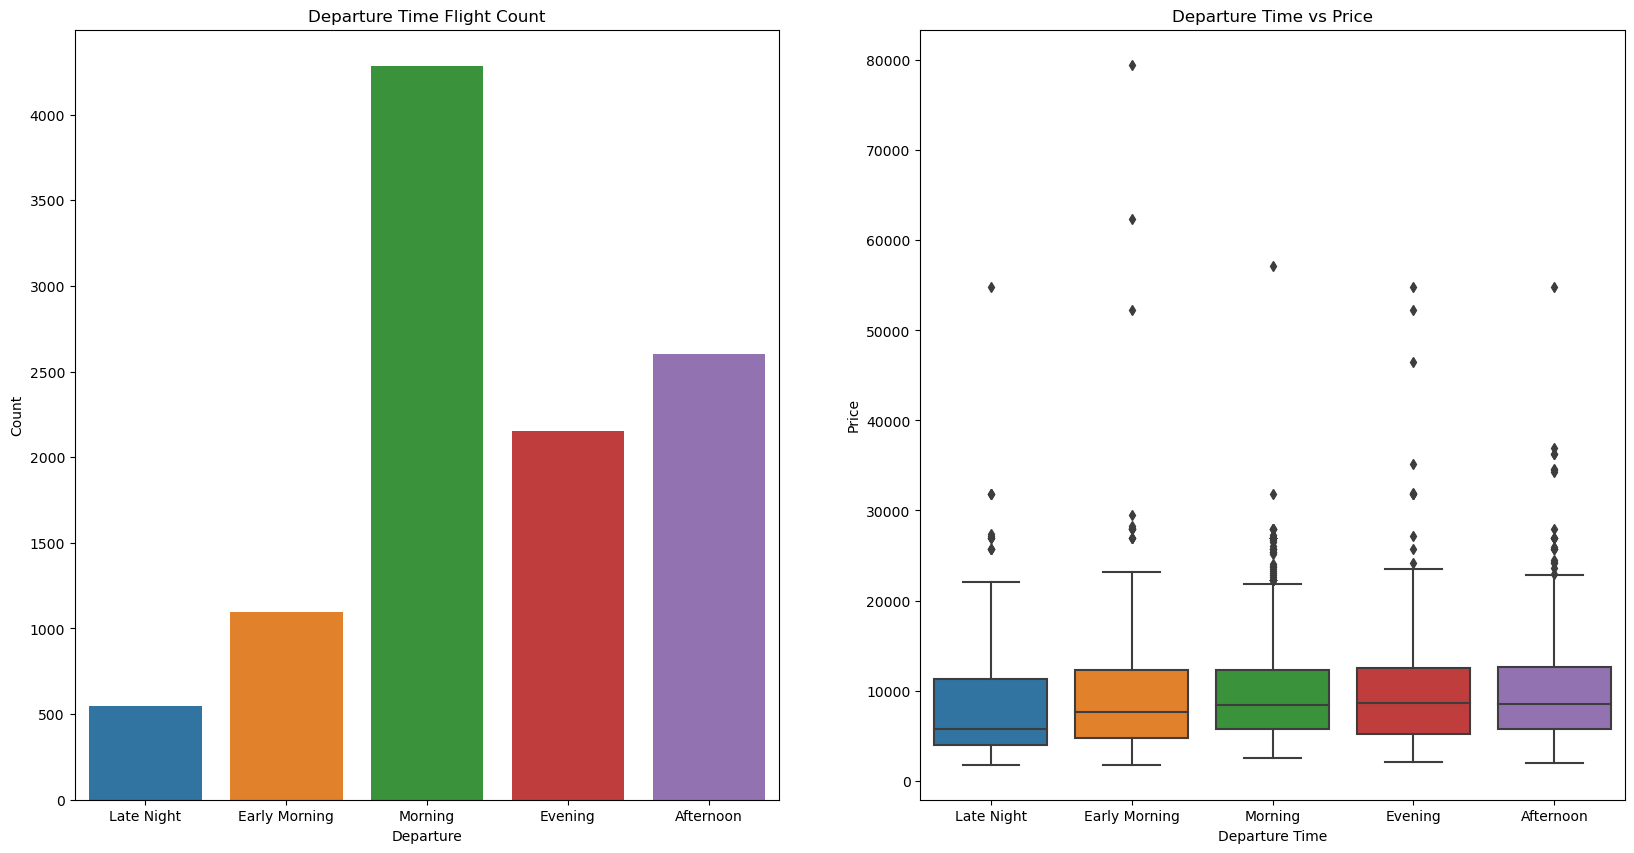

In [19]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.countplot(x='Departure',data=train)
plt.title('Departure Time Flight Count')
plt.ylabel('Count')

plt.subplot(1,2,2)
sns.boxplot(x='Departure',y='Price',data= train)
plt.title('Departure Time vs Price')
plt.xlabel('Departure Time')
plt.ylabel('Price')
plt.show()

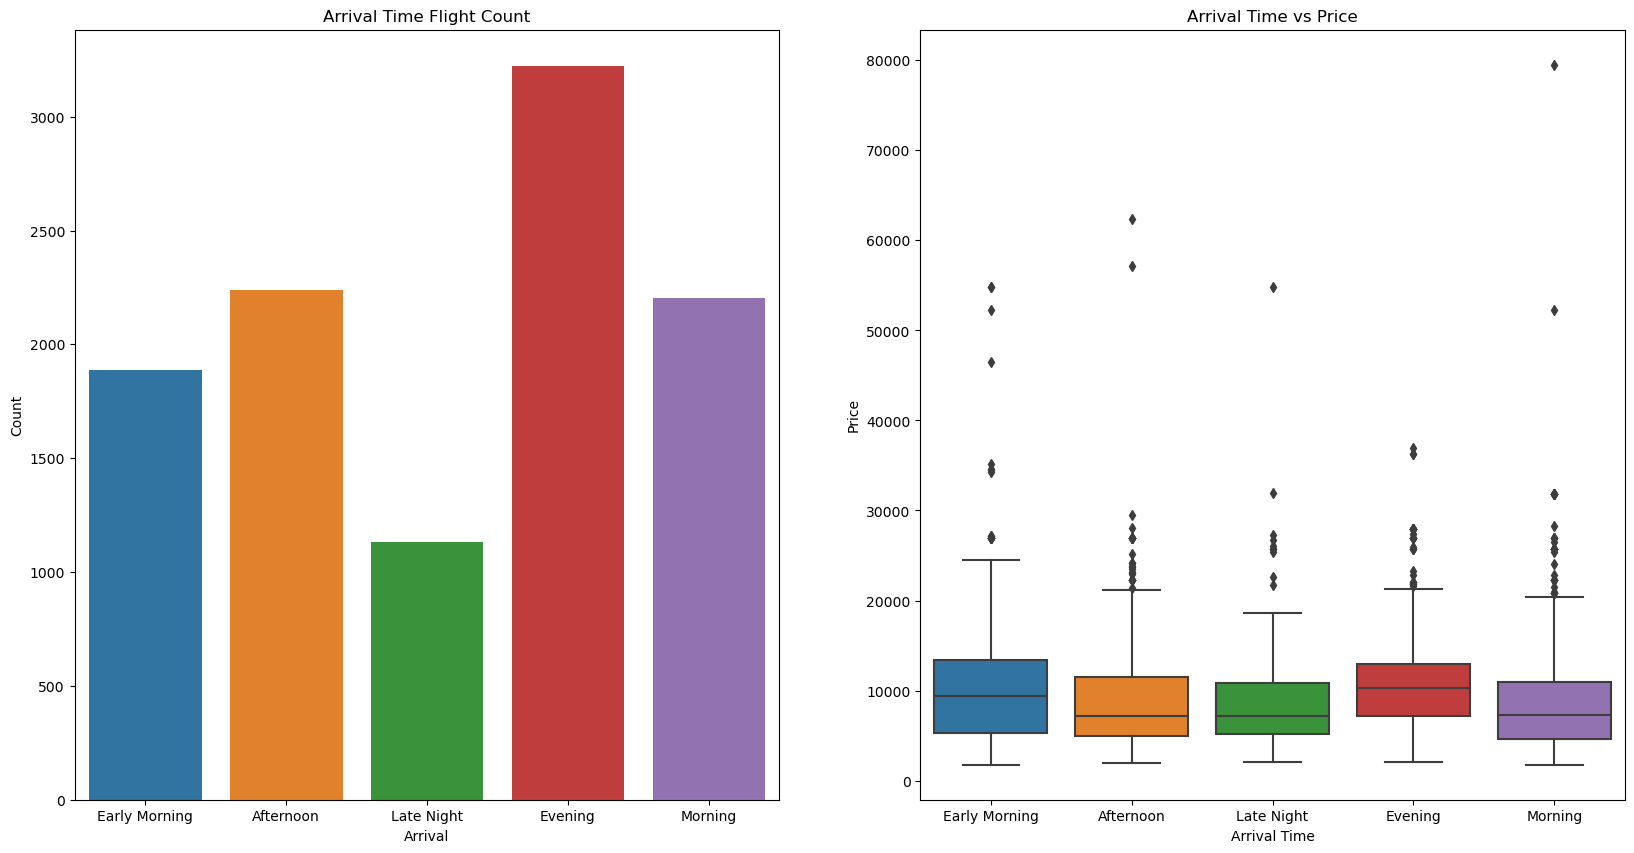

In [20]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.countplot(x='Arrival',data=train)
plt.title('Arrival Time Flight Count')
plt.ylabel('Count')

plt.subplot(1,2,2)
sns.boxplot(x='Arrival',y='Price',data= train)
plt.title('Arrival Time vs Price')
plt.xlabel('Arrival Time')
plt.ylabel('Price')
plt.show()

#### Observation:

Departure Time: There are quite a few outliers for Morning and Afternoon departure, which makes sense as the number of flights departing at the time are quite high. Even though there are a few outliers for Morning, they aren't that much.
    
Similarly for Arrival Time, there are quite a few outliers for Evening, Morning, and Afternoon departure as the number of flights arriving at the time are quite high. 

In [21]:
train['Date'] = pd.to_datetime(train['Date_of_Journey'], format='%d/%m/%Y')
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
train['Year'] = train['Date'].dt.year

test['Date'] = pd.to_datetime(test['Date_of_Journey'], format='%d/%m/%Y')
test['Month'] = test['Date'].dt.month
test['Day'] = test['Date'].dt.day
test['Year'] = test['Date'].dt.year

In [22]:
train['Year'].value_counts()

2019    10682
Name: Year, dtype: int64

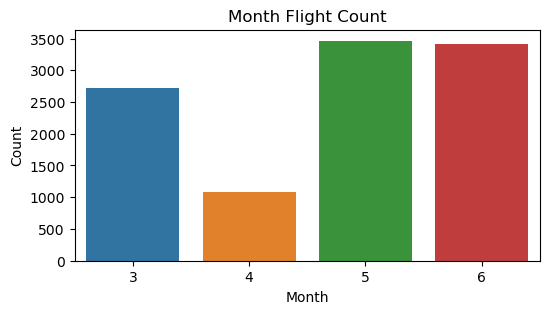

In [23]:
plt.figure(figsize=(6,3))
sns.countplot(x='Month',data=train)
plt.title('Month Flight Count')
plt.ylabel('Count')
plt.show()

#### Observation:

There are a lot more flights being taken in the summer (May and June)

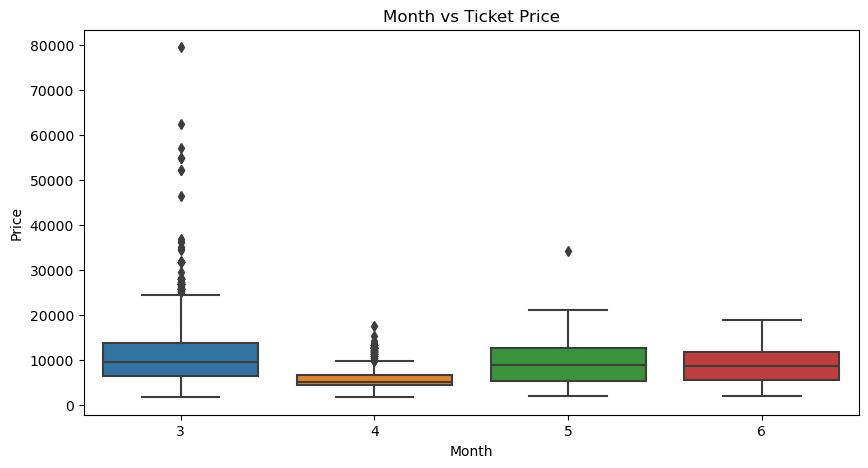

In [24]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Month',y='Price',data=train)
plt.title('Month vs Ticket Price')
plt.xlabel('Month')
plt.ylabel('Price')
plt.show()

In [25]:
def extract_time_components(df, time_column1, time_column2, format='%H:%M'):
    df[time_column1] = pd.to_datetime(df[time_column1], format=format)
    df[time_column2] = pd.to_datetime(df[time_column2], format=format)

    df['Dept_Hour'] = df[time_column1].dt.hour
    df['Dept_Minute'] = df[time_column1].dt.minute
    
    df['Arr_Hour'] = df[time_column2].dt.hour
    df['Arr_Min'] = df[time_column2].dt.minute

    return df

train = extract_time_components(train, 'Dep_Time', 'Arr_Time')
test = extract_time_components(test, 'Dep_Time', 'Arr_Time')

In [26]:
train['Airline'].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

In [27]:
test['Airline'].value_counts()

Jet Airways                          897
IndiGo                               511
Air India                            440
Multiple carriers                    347
SpiceJet                             208
Vistara                              129
Air Asia                              86
GoAir                                 46
Multiple carriers Premium economy      3
Vistara Premium economy                2
Jet Airways Business                   2
Name: Airline, dtype: int64

#### Observation:

To deal with the Airline categories having lesser counts, we'll group them into an "Other" category to reduce noise

In [28]:
replace_with_others = ['Multiple carriers Premium economy', 'Jet Airways Business','Vistara Premium economy', 'Trujet']

train['Airline'] = train['Airline'].replace(replace_with_others, 'Others')
test['Airline'] = test['Airline'].replace(replace_with_others, 'Others')

In [29]:
train['Additional_Info'].value_counts()

No info                         8344
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

In [30]:
test['Additional_Info'].value_counts()

No info                         2148
In-flight meal not included      444
No check-in baggage included      76
1 Long layover                     1
Business class                     1
Change airports                    1
Name: Additional_Info, dtype: int64

#### Observation:

Similar to what we did for Airline, we'll group smaller Additional Info cats to reduce noise

In [31]:
train['Additional_Info'].replace({'Change airports':'Other', 
                                  'Business class':'Other',
                                  '1 Short layover':'Other',
                                  '1 Long layover':'Other',
                                  'Red-eye flight':'Other',
                                  '2 Long layover':'Other',
                                  'No info':'No Info'},inplace=True)

test['Additional_Info'].replace({'Change airports':'Other', 
                                 'Business class':'Other',
                                 '1 Short layover':'Other',
                                 '1 Long layover':'Other',
                                 'Red-eye flight':'Other',
                                 '2 Long layover':'Other',
                                 'No info':'No Info'},inplace=True)

In [32]:
train['Additional_Info'].value_counts()

No Info                         8347
In-flight meal not included     1982
No check-in baggage included     320
Other                             33
Name: Additional_Info, dtype: int64

In [33]:
test['Additional_Info'].value_counts()

No Info                         2148
In-flight meal not included      444
No check-in baggage included      76
Other                              3
Name: Additional_Info, dtype: int64

#### Observation:

Mapping New Delhi to Delhi in both Source and Destination to avoid inconsistency

In [34]:
train['Source'].replace({'New Delhi':'Delhi'},inplace=True)
test['Source'].replace({'New Delhi':'Delhi'},inplace=True)

train['Destination'].replace({'New Delhi':'Delhi'},inplace=True)
test['Destination'].replace({'New Delhi':'Delhi'},inplace=True)

In [35]:
def duration_to_minutes(duration):
    hours = 0
    minutes = 0
    if 'h' in duration:
        parts = duration.split('h')
        hours = int(parts[0]) if parts[0] else 0
        if len(parts) > 1 and parts[1]:
            minutes = int(parts[1].replace('m', ''))
    else:
        minutes = int(duration.replace('m', ''))
    total_minutes = hours * 60 + minutes
    return total_minutes

train['Duration_Min'] = train['Duration'].apply(duration_to_minutes)
test['Duration_Min'] = test['Duration'].apply(duration_to_minutes)

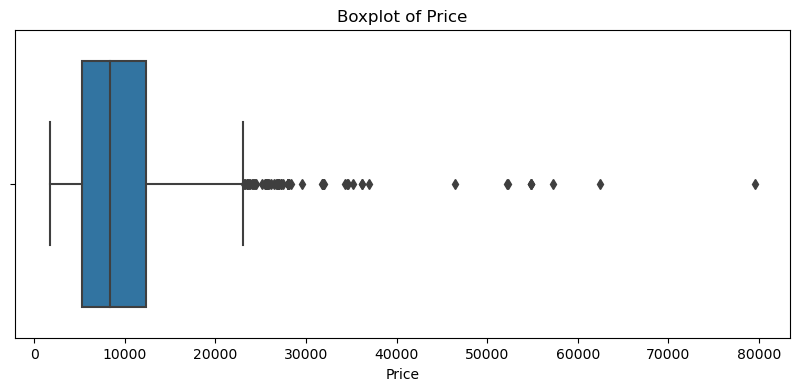

In [36]:
plt.figure(figsize=(10,4))
sns.boxplot(x= train['Price'])
plt.title('Boxplot of Price')
plt.xlabel('Price')
plt.show()

In [37]:
skewness = train['Price'].skew()
print(f"The skewness of the price distribution is: {skewness}")

The skewness of the price distribution is: 1.812404554693161


#### Observation:

The Skewness is quite high, Log transformation could help

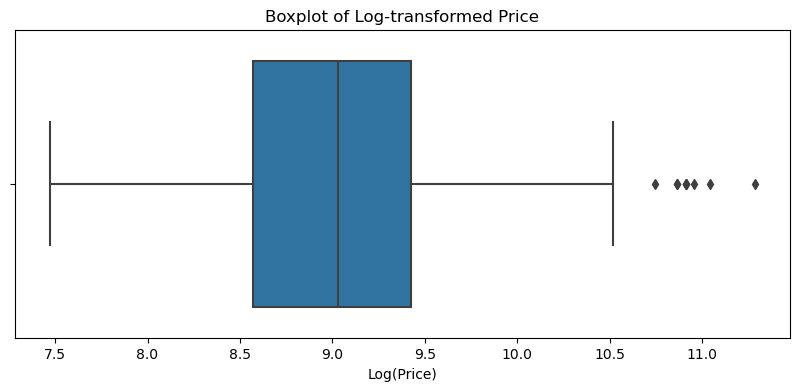

In [38]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=train['Price'].apply(lambda x: np.log(x+1)))
plt.title('Boxplot of Log-transformed Price')
plt.xlabel('Log(Price)')
plt.show()

#### Observation:

Log transformation would help in reducing outliers but there would still be a few. Let's winsorize!

In [39]:
train['Log_Price'] = np.log1p(train['Price'])
train['Winsorized_Log_Price'] = winsorize(train['Log_Price'], limits=[0.05, 0.05])

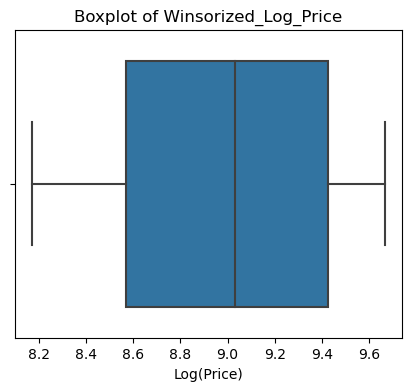

In [40]:
plt.figure(figsize=(5, 4))
sns.boxplot(x=train['Winsorized_Log_Price'])
plt.title('Boxplot of Winsorized_Log_Price')
plt.xlabel('Log(Price)')
plt.show()

#### Observation:

Much better!

In [41]:
train_cols_drop = ['Date_of_Journey','Dep_Time','Arrival_Time','Date','Arr_Time','Duration','Price','Log_Price','Year']
test_cols_drop = ['Date_of_Journey','Dep_Time','Arrival_Time','Date','Arr_Time','Duration','Year']
train = train.drop(train_cols_drop,axis=1)
test = test.drop(test_cols_drop,axis=1)

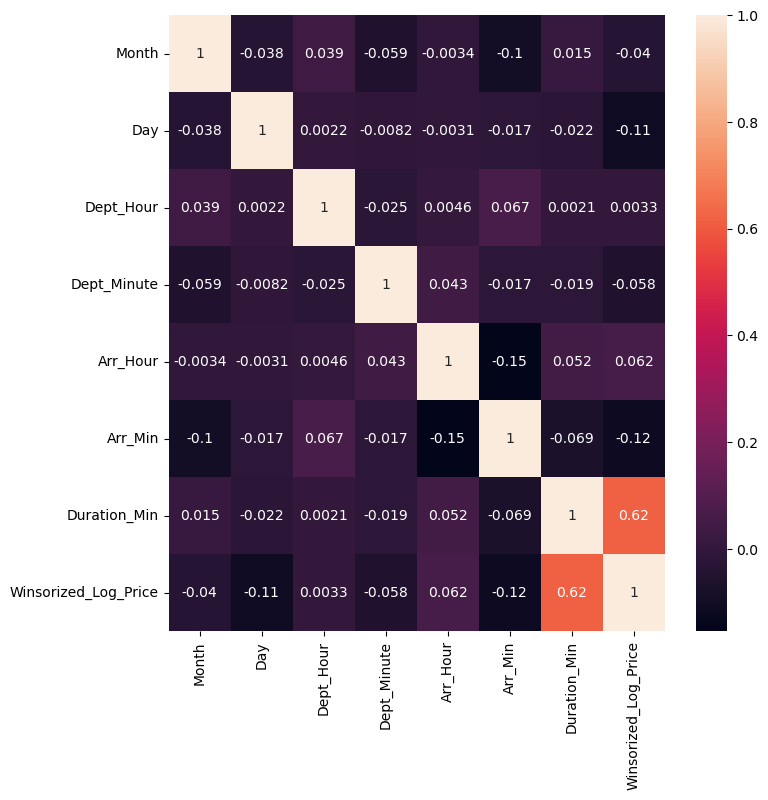

In [42]:
plt.figure(figsize = (8,8))
sns.heatmap(train.corr(), annot = True)
plt.show()

In [43]:
print("Observing the categorical column disribution before encoding: \n")

cols_cat = ['Airline','Source','Destination','Total_Stops','Additional_Info','Departure','Arrival']
for columns in cols_cat:
    print(columns, '\n')
    print(train[columns].value_counts(),'\n')

Observing the categorical column disribution before encoding: 

Airline 

Jet Airways          3849
IndiGo               2053
Air India            1751
Multiple carriers    1196
SpiceJet              818
Vistara               479
Air Asia              319
GoAir                 194
Others                 23
Name: Airline, dtype: int64 

Source 

Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64 

Destination 

Cochin       4536
Banglore     2871
Delhi        2197
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64 

Total_Stops 

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64 

Additional_Info 

No Info                         8347
In-flight meal not included     1982
No check-in baggage included     320
Other                             33
Name: Additional_Info, dtype: int64 

Departure 

Morning          4282
Afternoon        2604
Evening 

In [44]:
train['Route'].value_counts()

DEL → BOM → COK          2376
BLR → DEL                1552
CCU → BOM → BLR           979
CCU → BLR                 724
BOM → HYD                 621
                         ... 
CCU → VTZ → BLR             1
CCU → IXZ → MAA → BLR       1
BOM → COK → MAA → HYD       1
BOM → CCU → HYD             1
BOM → BBI → HYD             1
Name: Route, Length: 128, dtype: int64

#### Observations:

Route has too many values, let's apply Frequency encoding

In [45]:
route_counts = train['Route'].value_counts().to_dict()

train['Route_Frequency'] = train['Route'].map(route_counts)
test['Route_Frequency'] = test['Route'].map(route_counts)

train = train.drop('Route',axis=1)
test = test.drop('Route',axis=1)

In [46]:
encoder = LabelEncoder()
for columns in cols_cat:
    train[columns] = encoder.fit_transform(train[columns])
    test[columns] = encoder.fit_transform(test[columns])

print("Observing the categorical column disribution after encoding: \n")    
for columns in cols_cat:
    print(columns, '\n')
    print(train[columns].value_counts(),'\n')

Observing the categorical column disribution after encoding: 

Airline 

4    3849
3    2053
1    1751
5    1196
7     818
8     479
0     319
2     194
6      23
Name: Airline, dtype: int64 

Source 

2    4536
3    2871
0    2197
4     697
1     381
Name: Source, dtype: int64 

Destination 

1    4536
0    2871
2    2197
3     697
4     381
Name: Destination, dtype: int64 

Total_Stops 

0    5625
4    3491
1    1520
2      45
3       1
Name: Total_Stops, dtype: int64 

Additional_Info 

1    8347
0    1982
2     320
3      33
Name: Additional_Info, dtype: int64 

Departure 

4    4282
0    2604
2    2154
1    1094
3     548
Name: Departure, dtype: int64 

Arrival 

2    3221
0    2240
4    2203
1    1886
3    1132
Name: Arrival, dtype: int64 



In [47]:
correlation_matrix = train.corr()
target_correlations = correlation_matrix['Winsorized_Log_Price']
print(target_correlations)

Airline                -0.040449
Source                  0.077139
Destination            -0.375655
Total_Stops            -0.695207
Additional_Info        -0.184740
Departure              -0.002202
Arrival                -0.056521
Month                  -0.040397
Day                    -0.112019
Dept_Hour               0.003300
Dept_Minute            -0.058044
Arr_Hour                0.061950
Arr_Min                -0.115608
Duration_Min            0.616624
Winsorized_Log_Price    1.000000
Route_Frequency         0.062354
Name: Winsorized_Log_Price, dtype: float64


## Modeling

In [48]:
X = train.drop('Winsorized_Log_Price', axis=1)
y = train['Winsorized_Log_Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [49]:
classifiers = [
    LinearRegression(),
    ElasticNet(),
    RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]),
    Lasso(alpha =16, random_state=100),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    AdaBoostRegressor(),
    SVR(), 
    xgb.XGBRegressor()]

name = []
score = []
models = []
rmse = []
r_2_score = []
i = 0
for classifier in classifiers:
    classifier.fit(X_train, y_train)   
    name.append(type(classifier).__name__)
    score.append(classifier.score(X_test, y_test))
    models.append(classifier)
    rmse.append(np.sqrt(mean_squared_error(classifier.predict(X_test), y_test)))
    r_2_score.append(r2_score(classifier.predict(X_test), y_test))

In [50]:
df_score = pd.DataFrame(list(zip(name,rmse,r_2_score,score, models)),columns=['name','rmse','r2_score','score',"model"])
df_score.set_index('name',inplace=True)
df_score.sort_values(by=['score'],inplace=True)
df_score

,rmse,r2_score,score,model
name,,,,
Lasso,0.364501,-0.965990,0.404442,"Lasso(alpha=16, random_state=100)"
ElasticNet,0.361464,-0.510280,0.414326,ElasticNet()
RidgeCV,0.305209,0.271923,0.582439,"RidgeCV(alphas=[0.001, 0.01, 0.1, 1])"
LinearRegression,0.305209,0.271934,0.582439,LinearRegression()
SVR,0.294032,0.488338,0.612462,SVR()
AdaBoostRegressor,0.260487,0.212764,0.695843,"(DecisionTreeRegressor(max_depth=3, random_sta..."
GradientBoostingRegressor,0.164917,0.851023,0.878085,([DecisionTreeRegressor(criterion='friedman_ms...
DecisionTreeRegressor,0.147120,0.902910,0.902979,DecisionTreeRegressor()
RandomForestRegressor,0.113254,0.939139,0.942505,"(DecisionTreeRegressor(max_features=1.0, rando..."


In [51]:
model = df_score.loc["XGBRegressor","model"]
predict = model.predict(test)
predict

array([9.546923, 8.391358, 9.421345, ..., 9.688357, 9.50714 , 8.941837],
      dtype=float32)

In [52]:
test['Prediction_Price'] = predict
test

,Airline,Source,Destination,Total_Stops,Additional_Info,Departure,Arrival,Month,Day,Dept_Hour,Dept_Minute,Arr_Hour,Arr_Min,Duration_Min,Route_Frequency,Prediction_Price
0,4,2,1,0,1,0,1,6,6,17,30,4,25,655,2376.0,9.546923
1,3,3,0,0,1,4,4,5,12,6,20,10,20,240,65.0,8.391358
2,4,2,1,0,0,2,2,5,21,19,15,19,0,1425,2376.0,9.421345
3,5,2,1,0,1,4,2,5,21,8,0,21,0,780,2376.0,9.304470
4,0,0,2,4,1,3,1,6,24,23,55,2,45,170,1552.0,8.232340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,1,3,0,0,1,2,2,6,6,20,30,20,25,1435,565.0,9.224380
2667,3,3,0,4,1,0,0,3,27,14,20,16,55,155,724.0,8.482618
2668,4,2,1,0,1,2,1,3,6,21,50,4,25,395,2376.0,9.688357
2669,1,2,1,0,1,1,2,3,6,4,0,19,15,915,2376.0,9.507140


#### Observation:

Let's scaleback the price column

In [53]:
test['Prediction_Price'] = np.exp(test['Prediction_Price'])
test

,Airline,Source,Destination,Total_Stops,Additional_Info,Departure,Arrival,Month,Day,Dept_Hour,Dept_Minute,Arr_Hour,Arr_Min,Duration_Min,Route_Frequency,Prediction_Price
0,4,2,1,0,1,0,1,6,6,17,30,4,25,655,2376.0,14001.541016
1,3,3,0,0,1,4,4,5,12,6,20,10,20,240,65.0,4408.802246
2,4,2,1,0,0,2,2,5,21,19,15,19,0,1425,2376.0,12349.177734
3,5,2,1,0,1,4,2,5,21,8,0,21,0,780,2376.0,10987.022461
4,0,0,2,4,1,3,1,6,24,23,55,2,45,170,1552.0,3760.622803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,1,3,0,0,1,2,2,6,6,20,30,20,25,1435,565.0,10141.381836
2667,3,3,0,4,1,0,0,3,27,14,20,16,55,155,724.0,4830.080078
2668,4,2,1,0,1,2,1,3,6,21,50,4,25,395,2376.0,16128.728516
2669,1,2,1,0,1,1,2,3,6,4,0,19,15,915,2376.0,13455.458984
